In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7028/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)



[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)

In [5]:
width = 0.015
ang = jnp.pi
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    17,17,100
)

In [6]:
enumerators = b.make_enumerator(["contact_params_1"])

In [7]:
key = jax.random.PRNGKey(100)

In [8]:
def make_orientation_posterior_viz(observation, gt_contact, sampled_contacts):
    fig = plt.figure(constrained_layout=True)
    # fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.set_aspect(1.0)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
    ax.add_patch(circ)
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-2.0, 2.0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter(-jnp.sin(sampled_contacts[:,2]),jnp.cos(sampled_contacts[:,2]),label="Posterior Samples", alpha=0.5, s=15)
    ax.scatter(-jnp.sin(gt_contact[2]),jnp.cos(gt_contact[2]), color=(1.0, 0.0, 0.0),label="Actual", alpha=0.9, s=10)
    ax.set_title("Posterior on Orientation (top view)")
    ax.legend(fontsize=9)
    # plt.show()
    return fig

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 20/50 [00:16<00:24,  1.21it/s]/var/tmp/ipykernel_538206/903676468.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.20it/s]


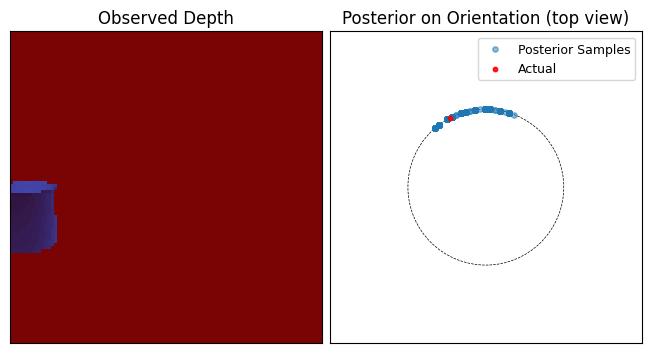

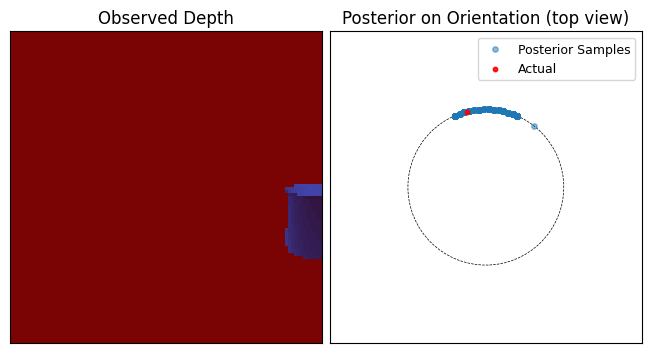

In [ ]:
key = jax.random.PRNGKey(100)
pathlib.Path('mug_results').mkdir(parents=True, exist_ok=True) 
for experiment_iteration in tqdm(range(50)):
    key = jax.random.split(key, 1)[0]
    weight, trace = importance_jit(key, genjax.choice_map({
        "parent_0": -1,
        "parent_1": 0,
        "id_0": jnp.int32(21),
        "id_1": jnp.int32(13),
        "camera_pose": jnp.eye(4),
        "root_pose_0": table_pose,
        "face_parent_1": 3,
        "face_child_1": 2,
        "variance": 0.0001,
        "outlier_prob": 0.0000001,
        # "contact_params_1": jnp.array([0.15, 0.0, 0.0])
    }), (
        jnp.arange(2),
        jnp.arange(22),
        jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
        jnp.array([jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])]),
        b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
    )
    b.show_trimesh("1", b.RENDERER.meshes[13])
    b.set_pose("1", b.get_poses(trace)[1])
    
    contact_param_grid = trace["contact_params_1"] + contact_param_deltas
    weights =  jnp.concatenate([
        enumerators[3](trace, key, cp)
        for cp in jnp.array_split(contact_param_grid, 50)
    ],axis=0)
    sampled_contact_params = contact_param_grid[jax.random.categorical(key, weights, shape=(1000,))]
    
    fig = make_orientation_posterior_viz(trace["image"], trace["contact_params_1"], sampled_contact_params)
    fig.savefig(f'mug_results/{experiment_iteration:05d}.png')


In [10]:
import imageio
images = [imageio.imread(f'results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(50))]
imageio.mimsave("mug_results.gif", images, 'GIF', duration=1200)

  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]/var/tmp/ipykernel_536983/2655208105.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(50))]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.72it/s]
